### 1. Back End. Парсинг HTML сохранение данных в SQL 

In [1]:
import requests as r
from bs4 import BeautifulSoup as bs
import sqlite3
import statistics as st
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats

In [2]:
# Переменные
headers = {'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/605.1.15 \
           (KHTML, like Gecko) Version/12.1 Safari/605.1.15"}
# Формирование url вида:
# https://hh.ru/search/vacancy?search_period=30&clusters=true&area=1&text=Python&enable_snippets=true&page=0
str_search = 'Python'
url = 'https://hh.ru/search/vacancy'
payload = {'search_period':30,  
           'area':[1,2], # 1 - Москва, 2 - Питер
           'text': str_search, 
           'page':0}
    
page_count = 100 # Кол-во обрабатываемых страниц с сайта hh.ru
db_file = 'hh.db' # Имя файла с Data Base
sql_create_table_hh = """ CREATE TABLE IF NOT EXISTS hh (
                                    id integer PRIMARY KEY,
                                    title text, 
                                    href test, 
                                    company text, 
                                    address text, 
                                    responsibility text,
                                    requirement text,
                                    salary_min integer,
                                    salary_max integer,
                                    skills text
                                ); """
currency_usd = 64.42 # Курс USD
currency_eur = 71.84 # Курс EUR

In [3]:
############### Функции для работы с sqlite #########################################
def create_connection(db_file):
    """ 
        create a database connection to the SQLite database specified by db_file
        :param db_file: database file
        :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ 
        create a table from the create_table_sql statement
        :param conn: Connection object
        :param create_table_sql: a CREATE TABLE statement
        :return:
    """
    try:
        cur = conn.cursor()
        cur.execute(create_table_sql)
    except Error as e:
        print(e)

def insert_data(conn, data):
    """
        Create a new data into the hh table
        :param conn: Connection object
        :param data:
        :return: id
    """
    sql = ''' INSERT INTO hh(title, href, company, address, responsibility, requirement, salary_min, \
                                salary_max, skills) VALUES(?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, data)
    return cur.lastrowid

def select_data(conn, sql_query):
    """
        Select data from DB
        :param conn: Connection object
        :param sql_query: sql query
        :return: id
    """
    cur = conn.cursor()
    cur.execute(sql_query)
    return cur.fetchall()


def drop_table(conn, table_name):
    """ 
        drop table
        :param conn: Connection object
        :param table_name: table name
        :return:
    """
    sql = """ DROP TABLE IF EXISTS %s """ % table_name
    try:
        cur = conn.cursor()
        cur.execute(sql)
    except Error as e:
        print(e)

#################################################################################  

In [4]:
#################### Функция парсинга HTML в SQL ################################
def html2sql(url, payload, headers, conn):
    request = r.get(url, params=payload, headers=headers)
    print("Request URL:\n{}".format(request.url))
    if request.status_code == 200:
        soup = bs(request.content, 'html.parser')
        divs = soup.find_all("div", attrs= {"data-qa":"vacancy-serp__vacancy"})
        
        for div in divs:
            title = div.find("a", attrs = {"data-qa":"vacancy-serp__vacancy-title"}).text
            href = div.find("a", attrs = {"data-qa":"vacancy-serp__vacancy-title"})['href']
            try:
                company = div.find('a', attrs = {"data-qa":"vacancy-serp__vacancy-employer"}).text
            except:
                company = 'Unknown'
            address = div.find('span', attrs = {"data-qa":"vacancy-serp__vacancy-address"}).text
            responsibility = div.find('div', attrs = {"data-qa":"vacancy-serp__vacancy_snippet_responsibility"}).text
            requirement = div.find('div', attrs = {"data-qa":"vacancy-serp__vacancy_snippet_requirement"}).text
            try:
                salary = div.find("div", attrs = {"data-qa":"vacancy-serp__vacancy-compensation"}).text.replace('\xa0', '')
                salary_min, salary_max = parsing_salary(salary)
            except AttributeError:
                salary_min, salary_max = '0','0'
                
            # Парсинг Ключевых навыков
            skills = skills2sql(href, headers)
    
            # Insert data to SQL:
            data = (title, href, company, address, responsibility, requirement, salary_min, salary_max, skills)
            insert_data(conn, data)
        
        print('Done\n')
    else:
        print("Error!!! Status code: ", request.status_code)


#################### Функция парсинга навыков (skill) из вакансий ################################
def skills2sql(vacancy_url, headers):
    request = r.get(vacancy_url, headers=headers)
    #print("Request URL:\n{}".format(request.url))
    if request.status_code == 200:
        soup = bs(request.content, 'html.parser')
        divs = soup.find_all("span", attrs= {"data-qa":"skills-element"})
        skills = []
        for div in divs:
            skill = div.find("span", attrs = {"data-qa":"bloko-tag__text"}).text.lower()
            skills.append(skill)
        if len(skills) == 0:
            skills = ['No skills']
        skills = ', '.join(skills)
        return skills
    else:
        print("Error!!! Status code: ", request.status_code)


#################### Функция парсинга salary ################################
def parsing_salary(salary):
    salary_dig = salary.lower().replace('от ', '').replace('до ', '0 ').replace('-', ' ').split()
    if len(salary_dig) == 2:
        result=[salary_dig[0],'0',salary_dig[1]]
        if result[2] == 'eur':
            result = [float(result[0]) * currency_eur, float(result[1]) * currency_eur]
        elif result[2] == 'usd':
            result = [float(result[0]) * currency_usd, float(result[1]) * currency_usd]
        else:
            result = [float(result[0]), float(result[1])]
        
    elif len(salary_dig) == 3:
        result=salary_dig
        if result[2] == 'eur':
            result = [float(result[0]) * currency_eur, float(result[1]) * currency_eur]
        elif result[2] == 'usd':
            result = [float(result[0]) * currency_usd, float(result[1]) * currency_usd]
        else:
            result = [float(result[0]), float(result[1])]
    else:
        print('Error parsing salary field!!!')
    
    return result


In [5]:
################################  Main program ###############################

# Create a database connection
conn = create_connection(db_file)
if conn is not None:
    # create hh table
    create_table(conn, sql_create_table_hh)
else:
    print("Error! cannot create the database connection.")

# Parsing HTML to DB
with conn:
    for page in range(page_count): # Go to page
        payload['page'] = page
        html2sql(url, payload, headers, conn)

##############################################################################

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=0
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=1
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=2
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=3
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=4
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=5
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=6
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=7
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=8
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=9
Done

Request URL:
https:/

Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=83
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=84
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=85
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=86
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=87
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=88
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=89
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=90
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=91
Done

Request URL:
https://hh.ru/search/vacancy?search_period=30&area=1&area=2&text=Python&page=92
Done

Requ

In [ ]:
# Удаление таблицы hh из DB
#drop_table(conn, 'hh')

### 2. Анализ данных, статистика

In [6]:
def histogram(data1, data2, out_file="histogram.png", label1="", label2="", cumulative=False, x_label = "", y_label = "", 
              title = "", color1 = 'green', color2 = 'blue'):
    set_matplotlib_formats('retina') # Для retina дисплеев. Что бы графики были четкие.
    #plt.xkcd() # Для отрисовки в стиле комиксов
    fig, ax = plt.subplots(figsize=(12, 5)) 
    ax.hist(data1, bins='sturges', cumulative = cumulative, color = color1, alpha=0.5,
            edgecolor='black', linewidth=1, align='right', label = label1)
    ax.hist(data2, bins='sturges', cumulative = cumulative, color = color2, alpha=0.5,
            edgecolor='black', linewidth=1, align='right', label = label2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.grid(color='grey', linestyle=':', linewidth=1) # Сетка
    ax.legend(loc='best', frameon=False)
    fig.savefig(out_file)   # save the figure to file

In [7]:
# Выборка из SQL
df_salary_min_msk = [i[0] for i in select_data(conn, ''' SELECT salary_min FROM hh \
                                                WHERE address LIKE '%Москва%' AND salary_min > 0 ''' )]
df_salary_max_msk = [i[0] for i in select_data(conn, ''' SELECT salary_max FROM hh \
                                                WHERE address LIKE '%Москва%' AND salary_max > 0 ''' )]
df_salary_min_spb = [i[0] for i in select_data(conn, ''' SELECT salary_min FROM hh \
                                                WHERE address LIKE '%Санкт-Петербург%' AND salary_min > 0 ''' )]
df_salary_max_spb = [i[0] for i in select_data(conn, ''' SELECT salary_max FROM hh \
                                                WHERE address LIKE '%Санкт-Петербург%' AND salary_max > 0 ''' )]

In [8]:
print('Кол-во вакансий для анализа с зарплатами: ',
      select_data(conn, ''' SELECT COUNT(*) FROM hh WHERE salary_min > 0 or salary_max > 0 ''' ))

Кол-во вакансий для анализа с зарплатами:  [(523,)]


#### Среднее

In [9]:
print('Средняя минимальная зарплата Москва: {:.2f} руб.'.format(st.mean(df_salary_min_msk)))
print('Средняя максимальная зарплата Москва: {:.2f} руб.'.format(st.mean(df_salary_max_msk)))
print()
print('Средняя минимальная зарплата Санкт-Петербург: {:.2f} руб.'.format(st.mean(df_salary_min_spb)))
print('Средняя максимальная зарплата Санкт-Петербург: {:.2f} руб.'.format(st.mean(df_salary_max_spb)))

Средняя минимальная зарплата Москва: 119574.51 руб.
Средняя максимальная зарплата Москва: 161391.08 руб.

Средняя минимальная зарплата Санкт-Петербург: 107428.56 руб.
Средняя максимальная зарплата Санкт-Петербург: 143738.96 руб.


#### Медиана

In [10]:
print('Медиана по минимальным зарплатам Москва: {:.2f} руб.'.format(st.median(df_salary_min_msk)))
print('Медиана по максимальным зарплатам Москва: {:.2f} руб.'.format(st.median(df_salary_max_msk)))
print()
print('Медиана по минимальным зарплатам Санкт-Петербург: {:.2f} руб.'.format(st.median(df_salary_min_spb)))
print('Медиана по максимальным зарплатам Санкт-Петербург: {:.2f} руб.'.format(st.median(df_salary_max_spb)))

Медиана по минимальным зарплатам Москва: 120000.00 руб.
Медиана по максимальным зарплатам Москва: 150000.00 руб.

Медиана по минимальным зарплатам Санкт-Петербург: 100000.00 руб.
Медиана по максимальным зарплатам Санкт-Петербург: 130000.00 руб.


#### Максимумы и минимумы

In [11]:
print('Минимальная зарплата Москва: {:.2f} руб.'.format(min(df_salary_min_msk)))
print('Максимальная зарплата Москва: {:.2f} руб.'.format(max(df_salary_max_msk)))
print()
print('Минимальная зарплата Санкт-Петербург: {:.2f} руб.'.format(min(df_salary_min_spb)))
print('Максимальная зарплата Санкт-Петербург: {:.2f} руб.'.format(max(df_salary_max_spb)))

Минимальная зарплата Москва: 90.00 руб.
Максимальная зарплата Москва: 400000.00 руб.

Минимальная зарплата Санкт-Петербург: 15000.00 руб.
Максимальная зарплата Санкт-Петербург: 300000.00 руб.


#### Гистограмма распределения зарплат

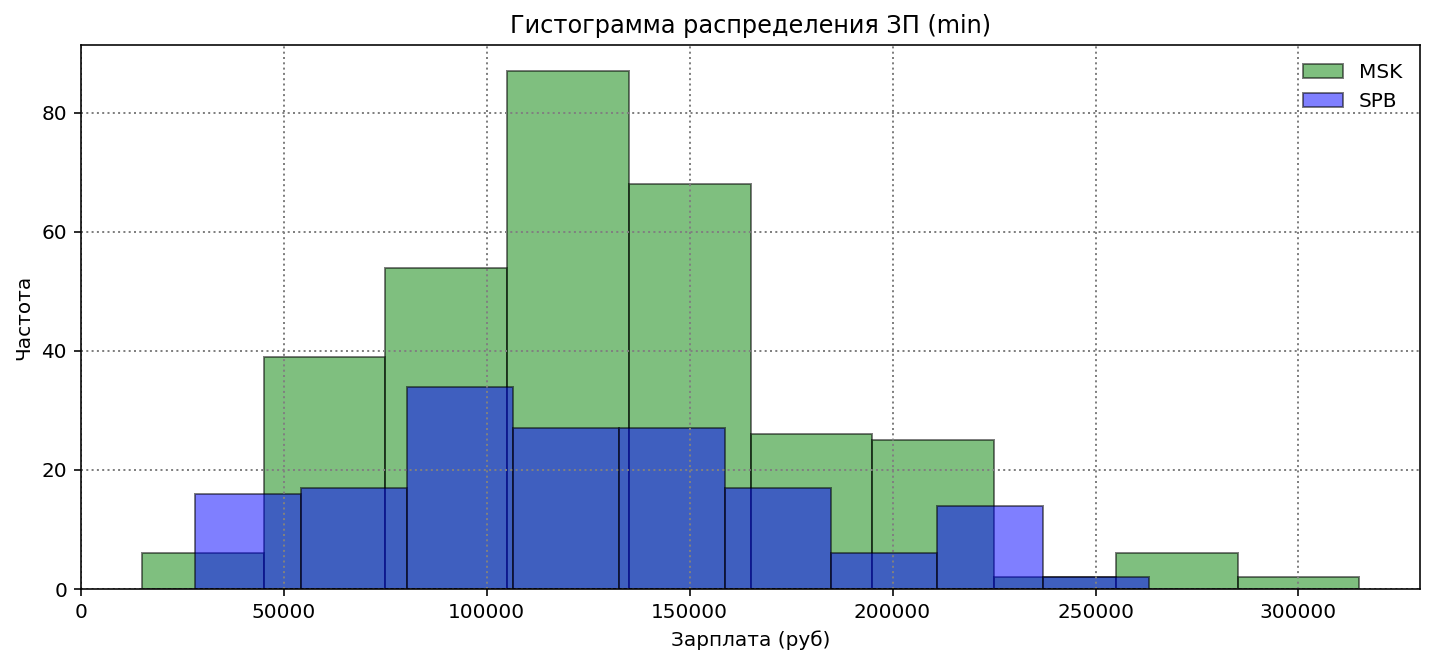

In [12]:
histogram(df_salary_min_msk, df_salary_min_spb, out_file='gist_salary_min.png', label1="MSK", label2="SPB",
          x_label = "Зарплата (руб)", y_label = "Частота", title = "Гистограмма распределения ЗП (min)")

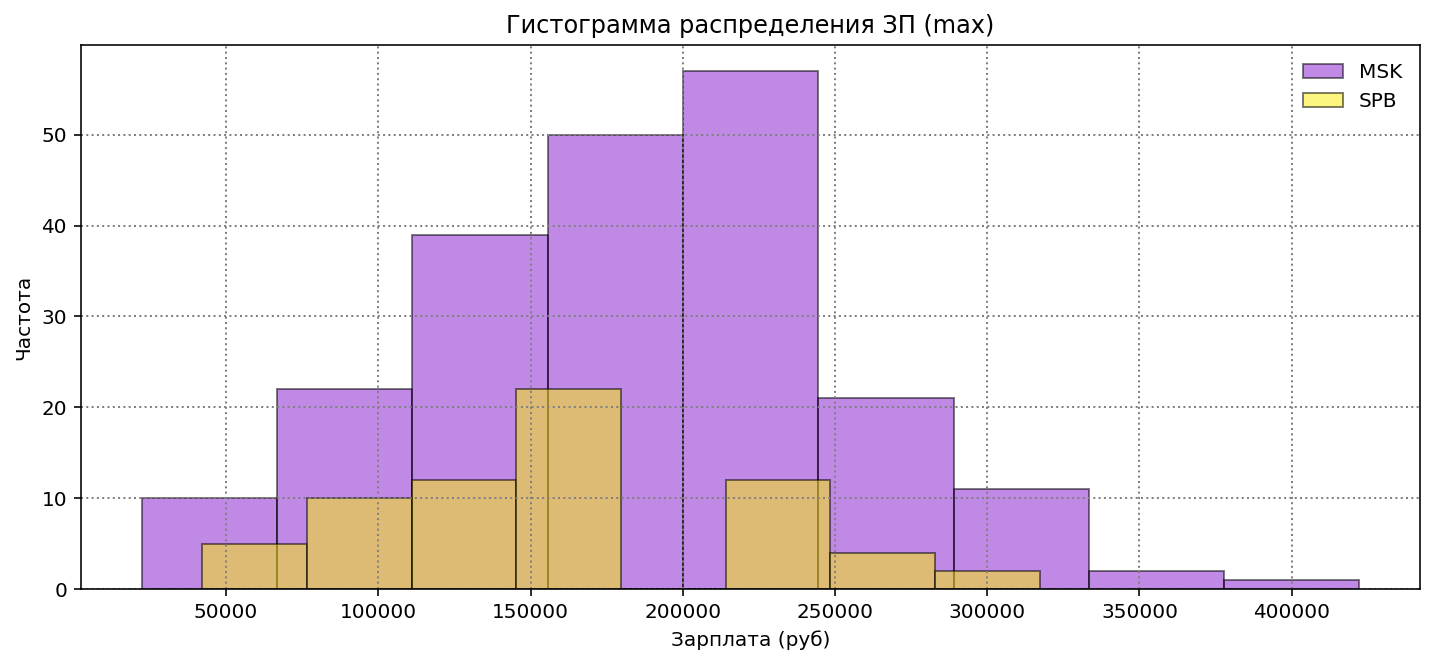

In [13]:
histogram(df_salary_max_msk, df_salary_max_spb, out_file='gist_salary_max.png', label1="MSK", label2="SPB", 
          x_label = "Зарплата (руб)", y_label = "Частота", title = "Гистограмма распределения ЗП (max)", 
          color1 = '#8314cc', color2 = '#faee05')

### 3. Top20 навыков

In [14]:
# Функция рисования горизонтальной гистограммы
def horizontal_barplot(data, x_label="", y_label="", title="", out_file="horizontal_bar.png", color = 'red'):
    set_matplotlib_formats('retina') # Для retina дисплеев. Что бы графики были четкие.
    #plt.xkcd() # Для отрисовки в стиле комиксов
    x_data, y_data = data[::,0], data[::,1]
    fig, ax = plt.subplots(figsize=(12, 6))
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.barh(x_data, y_data, color = color, align = 'center', edgecolor='black', linewidth=1, alpha=0.5)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.grid(color='grey', linestyle=':', linewidth=1) # Сетка
    fig.savefig(out_file)   # save the figure to file

In [15]:
# Функция подсчета TopN результатов
def top_resultat(data_list, top):
    '''
        data_list: list data
        top: number of top resultat
        return: sorted by value topN resultat and number of all results
    '''
    # Создаем словарь с нулевыми счетчиками
    d = dict.fromkeys(data_list, 0)
    # Считаем слова
    for count in data_list:
        d[count] += 1
    # Сортируем словарь по значению и по убыванию
    sorted_by_value = sorted(d.items(), key=lambda x: (x[1],x[0]), reverse=True)
    return sorted_by_value[0:top], len(sorted_by_value)

In [16]:
sql_query_skills = select_data(conn, ''' SELECT lower(skills) FROM hh WHERE skills !='No skills' ''' )
all_skills = ''.join([i[0]+', ' for i in sql_query_skills]).split(', ')[:-1]

In [17]:
sorted_by_value_20, sorted_by_value_full = top_resultat(all_skills, 20)

In [18]:
print('Top20 ключевых навыков:\n', sorted_by_value_20)
print('\nВсего ключевых навыков:', sorted_by_value_full)

Top20 ключевых навыков:
 [('python', 620), ('linux', 273), ('sql', 211), ('postgresql', 150), ('git', 148), ('c++', 137), ('javascript', 111), ('java', 105), ('mysql', 92), ('django framework', 88), ('docker', 67), ('bash', 64), ('php', 52), ('администрирование серверов linux', 51), ('ms sql', 51), ('c#', 49), ('тестирование', 48), ('qa', 45), ('html', 44), ('big data', 44)]

Всего ключевых навыков: 1185


In [19]:
# Сортировка списка в обратном порядке и преобразование в numpy массив для рисования гистограммы
sorted_by_value_revers_20 = np.array([i for i in reversed(sorted_by_value_20)])

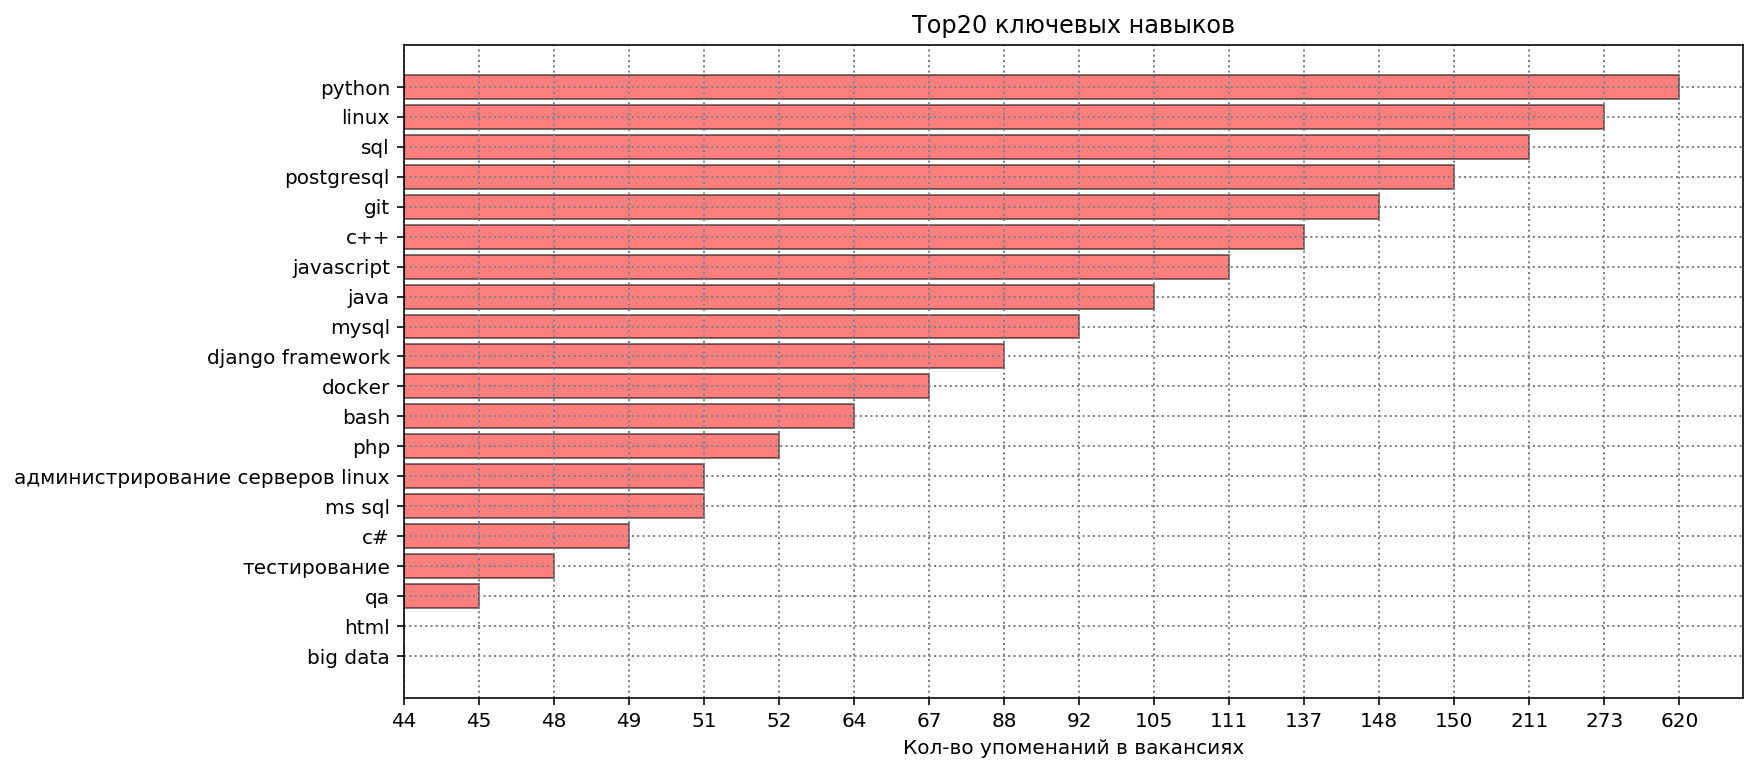

In [20]:
horizontal_barplot(sorted_by_value_revers_20, x_label="Кол-во упоменаний в вакансиях", title='Top20 ключевых навыков',
                  out_file="Top20_skill.png")

### 3. Top20 компаний-работодателей

In [21]:
sql_query_company = select_data(conn, ''' SELECT company FROM hh WHERE company !='Unknown' ''' )
all_company = ''.join([i[0].lstrip().rstrip().upper()+', ' for i in sql_query_company]).split(', ')[:-1]

In [22]:
company_sorted_by_value_20, company_sorted_by_value_full = top_resultat(all_company, 20)

In [23]:
print('Top20 компаний-работодателей:\n', company_sorted_by_value_20)
print('\nВсего компаний:', company_sorted_by_value_full)

Top20 компаний-работодателей:
 [('СБЕРБАНК ДЛЯ ЭКСПЕРТОВ', 55), ('ЯНДЕКС', 43), ('JETBRAINS', 33), ('MAIL.RU GROUP', 30), ('SELECTEL', 19), ('ТИНЬКОФФ', 17), ('ГРУППА КОМПАНИЙ', 16), ('ЧУ ДО ШКОЛА ПРОГРАММИСТОВ', 15), ('WARGAMING', 15), ('SAINT PETERSBURG (LESTA STUDIO)', 15), ('ПАО МТС', 14), ('ЦИАН ГРУПП', 13), ('С ОПЫТОМ РАБОТЫ', 13), ('«РОСБАНК', 13), ('SOCIETE GENERALE GROUP»', 13), ('LUXOFT', 13), ('ОТКРЫТАЯ МОБИЛЬНАЯ ПЛАТФОРМА', 12), ('X5 RETAIL GROUP', 12), ('DELL EMC', 12), ('ООО ИВИ.РУ', 11)]

Всего компаний: 807


In [24]:
# Сортировка списка в обратном порядке и преобразование в numpy массив для рисования гистограммы
company_sorted_by_value_revers_20 = np.array([i for i in reversed(company_sorted_by_value_20)])

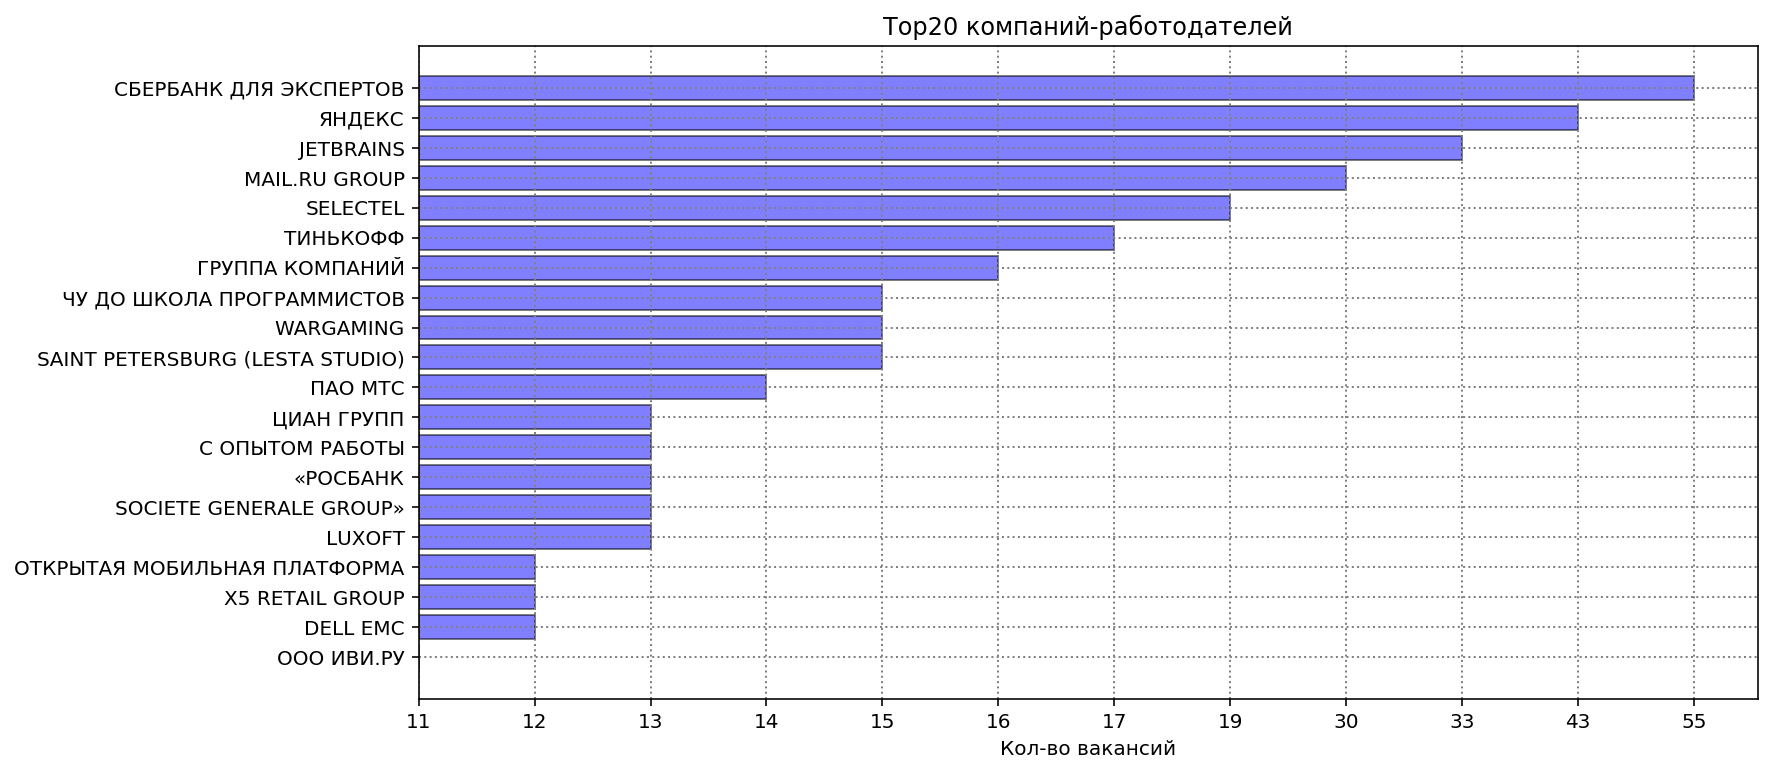

In [25]:
horizontal_barplot(company_sorted_by_value_revers_20, x_label="Кол-во вакансий", 
                   title='Top20 компаний-работодателей', out_file="Top20_company.png", color='blue')